In [245]:
# !pip install -r ../../prosodic/requirements.txt
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../hashstash')
sys.path.insert(0,'../../prosodic')
from tqdm.auto import tqdm
tqdm.pandas()
from multiprompt import *
# !pip install rapidfuzz
from rapidfuzz import fuzz
import numpy as np
import prosodic
stash = HashStash('rhyme_txt', engine='pairtree', serializer='pickle', compress=False)
# stash.clear()
import plotnine as p9

In [ ]:
CORPUS_ROOT = os.path.expanduser('~/lltk_data/corpora/chadwyck_poetry')

def get_chadwyck_corpus(ybin=50):
    df = pd.read_csv(os.path.join(CORPUS_ROOT, 'metadata.csv'))
    df=df.query(f'1600<=author_dob<2000')
    df['ybin'] = df.author_dob.apply(lambda x: f'b. {x//ybin*ybin:.0f}-{x//ybin*ybin+ybin:.0f}')
    return df.set_index('id')

df_meta = get_chadwyck_corpus(ybin=100)
df_meta.ybin.value_counts()

In [261]:
index='_id	_first_n_lines	_model	_say_poem	_version	_timestamp'.split()
df4=pd.read_pickle('data.output.gen_poems.v4.pkl').assign(_say_poem=True).reset_index().set_index(index)
df5=pd.read_pickle('data.output.gen_poems.v5.pkl').assign(_say_poem=True).reset_index().set_index(index)
df6=pd.read_pickle('data.output.gen_poems.v6.pkl')

In [ ]:
df6

In [263]:
# df6.reset_index()._model.perc_rhyming_lines.mean()

In [ ]:
df = pd.concat([
    df4.query('_model=="ollama/llama3.1:8b-text-q4_K_M" | _model=="ollama/mistral" | _model=="ollama/mistral:text"'),
    df5.query('_model=="ollama/llama3.1:8b"'),
    df6
])
df.reset_index()._model.value_counts()

In [ ]:
df['line_sim'] = df.progress_apply(lambda row: fuzz.ratio(row.line_real.strip(), row.line_gen.strip()) if row.line_gen and row.line_real else np.nan, axis=1)

In [ ]:
df.groupby(['_id','_model']).max(numeric_only=True).sort_values('line_sim').tail(25)

In [ ]:
df.query('_id=="english/sackvil2/Z200480105" & _model=="deepseek/deepseek-chat"').sort_values('line_sim',ascending=False)
df.index.names

In [ ]:
gby=[x for x in df.index.names if x]
num1=len(df.groupby(gby))
grps=[]
for g,gdf in df.groupby(gby): 
    if gdf.line_sim.max()<95:
        grps.append(gdf)
gdf = random.choice(grps)
df_safe = pd.concat(grps)
num1 - len(grps)

In [270]:

@stash.stashed_result
def get_txt_rhyming_data(txt, max_dist=0):
    bad_openings = ['Here is', 'Here\'s a', '**']
    lines1 = txt.split('\n')
    lines = [x for x in lines1 if not any(x.startswith(y) for y in bad_openings)][:1000]
    txt = '\n'.join(lines).strip()
    txt = '\n\n'.join([st for st in txt.split('\n\n') if st.count('\n')])
    poem = prosodic.Text(txt=txt)
    data = {'poem':txt}
    data['num_lines'] = poem.num_lines
    if data['num_lines']:
        rhymes = poem.get_rhyming_lines(max_dist=max_dist)
        rhymeset = set(rhymes.keys()) | set(rhymes.values())
        data['num_rhyming_lines'] = len(rhymeset)
        assert data['num_rhyming_lines'] <= data['num_lines']
        data['perc_rhyming_lines'] = data['num_rhyming_lines'] / data['num_lines'] * 100
    else:
        data['num_rhyming_lines'] = np.nan
        data['perc_rhyming_lines'] = np.nan
    return data

In [271]:
def compare_rhymes(df, keep_first_n_lines=False, keep_stanzas=True):
    poem_real = []
    poem_gen = []
    stanza_num = 1
    for i,row in df.iterrows():
        if keep_stanzas and row.stanza_num != stanza_num:
            poem_real.append('')
            poem_gen.append('')
            stanza_num = row.stanza_num

        if keep_first_n_lines or row.line_gen:
            poem_real.append(row.line_real)
            poem_gen.append(row.line_gen if row.line_gen else row.line_real)

    poem_real = '\n'.join(poem_real).strip()
    poem_gen = '\n'.join(poem_gen).strip()
    
    odx = dict(zip([x[1:] for x in gby], df.index.values[0]))
    
    for k,v in get_txt_rhyming_data(poem_real).items(): odx[k+'_real']=v
    for k,v in get_txt_rhyming_data(poem_gen).items(): odx[k+'_gen']=v
    odx['poem_sim'] = float(gdf.line_sim.mean())
    odx['perc_rhyming_lines_diff'] = odx['perc_rhyming_lines_gen'] - odx['perc_rhyming_lines_real']
    odx['num_rhyming_lines_diff'] = odx['num_rhyming_lines_gen'] - odx['num_rhyming_lines_real']
    odx['ybin'] = df_meta.loc[df.reset_index()._id.iloc[0]].ybin
    return odx

In [ ]:
x = compare_rhymes(gdf, keep_stanzas=False)
x

In [273]:
def compare_all_rhymes(df, keep_first_n_lines=False, keep_stanzas=True):
    o=[]
    for g,gdf in tqdm(list(df.groupby(gby))):
        try:
            o.append(compare_rhymes(gdf, keep_first_n_lines=keep_first_n_lines, keep_stanzas=keep_stanzas))
        except Exception:
            pass
    return pd.DataFrame(o)

In [ ]:
odf = compare_all_rhymes(df_safe, keep_first_n_lines=True, keep_stanzas=False)

In [275]:
odf[odf.num_lines_real>=8].model.value_counts()

model
ollama/llama3.1:8b                3389
ollama/mistral                    2046
ollama/mistral:text               1615
ollama/llama3.1:8b-text-q4_K_M    1598
Name: count, dtype: int64

In [276]:
odfq=odf.query('model=="ollama/llama3.1:8b-text-q4_K_M" & ybin=="b. 1900-2000"')
row=odfq.sample(1).iloc[0]
print(row.poem_gen)
row
odfq.sort_values('perc_rhyming_lines_gen')
odfq.perc_rhyming_lines_gen.mean()

Since I am out of my mind
I must be in my body;
There is nowhere else to be:
No fruit and all rind.
What is identity?
To me, it's the sum
Of all things that I see,
The whole of what's on show.
But is this really so?
I can't get rid of its shadow:
Since there are no words for "me,"
How can I know myself?
My mind is my own
But not the rest:
I am in the world, but also separate from it.
The body is a prison,
But also a vessel:
It contains me and yet cannot contain me.
Since, even as I move,
Who I really am does not change.


np.float64(10.101733632866809)

In [277]:
odf.query('ybin=="b. 1900-2000"').groupby('model').size()

model
ollama/llama3.1:8b                847
ollama/llama3.1:8b-text-q4_K_M    430
ollama/mistral                    636
ollama/mistral:text               423
dtype: int64

In [279]:
odf.query('ybin=="b. 1900-2000"').groupby('model').perc_rhyming_lines_gen.mean()
odf

,id,first_n_lines,model,say_poem,version,timestamp,poem_real,num_lines_real,num_rhyming_lines_real,perc_rhyming_lines_real,poem_gen,num_lines_gen,num_rhyming_lines_gen,perc_rhyming_lines_gen,poem_sim,perc_rhyming_lines_diff,num_rhyming_lines_diff,ybin
0,african-american/corrothe/Z200320798,5,ollama/llama3.1:8b,True,1,1.742539e+09,Down in the Southland once I found a vale\n ...,14,10,71.428571,Down in the Southland once I found a vale\n ...,14,9,64.285714,39.384118,-7.142857,-1,b. 1800-1900
1,african-american/corrothe/Z200320798,5,ollama/mistral,False,1,1.742581e+09,Down in the Southland once I found a vale\n ...,14,10,71.428571,Down in the Southland once I found a vale\n ...,14,10,71.428571,39.384118,0.000000,0,b. 1800-1900
2,african-american/corrothe/Z200320798,5,ollama/mistral:text,True,1,1.742489e+09,Down in the Southland once I found a vale\n ...,14,10,71.428571,Down in the Southland once I found a vale\n ...,14,5,35.714286,39.384118,-35.714286,-5,b. 1800-1900
3,african-american/dunbarpa/Z200343508,5,ollama/llama3.1:8b,False,1,1.742570e+09,"Search thou my heart;\n If there be guile,\...",20,14,70.000000,"Search thou my heart;\n If there be guile,\...",20,15,75.000000,39.384118,5.000000,1,b. 1800-1900
4,african-american/dunbarpa/Z200343508,5,ollama/llama3.1:8b,True,1,1.742539e+09,"Search thou my heart;\n If there be guile,\...",20,14,70.000000,"Search thou my heart;\n If there be guile,\...",20,17,85.000000,39.384118,15.000000,3,b. 1800-1900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8659,modern/sci0101/Z200480982,5,ollama/llama3.1:8b,False,1,1.742567e+09,"""When first made, the squares of glass\nabout ...",17,0,0.000000,"""When first made, the squares of glass\nabout ...",17,0,0.000000,39.384118,0.000000,0,b. 1900-2000
8660,modern/sci0101/Z200480982,5,ollama/llama3.1:8b,True,1,1.742539e+09,"""When first made, the squares of glass\nabout ...",17,0,0.000000,"""When first made, the squares of glass\nabout ...",17,2,11.764706,39.384118,11.764706,2,b. 1900-2000
8661,modern/sci0101/Z200480982,5,ollama/llama3.1:8b-text-q4_K_M,True,1,1.742476e+09,"""When first made, the squares of glass\nabout ...",17,0,0.000000,"""When first made, the squares of glass\nabout ...",17,0,0.000000,39.384118,0.000000,0,b. 1900-2000
8662,modern/sci0101/Z200480982,5,ollama/mistral,False,1,1.742576e+09,"""When first made, the squares of glass\nabout ...",17,0,0.000000,"""When first made, the squares of glass\nabout ...",17,0,0.000000,39.384118,0.000000,0,b. 1900-2000


In [299]:
pd.options.display.max_rows=100
p9.options.figure_size=(12,7)
# figdf = odf[odf.model=='ollama/llama3.1:8b'].melt(id_vars=['model', 'id','ybin'], value_vars=['perc_rhyming_lines_real', 'perc_rhyming_lines_gen'])


def get_figdf(odf):
    # figdf = odf#[odf.ybin.str.startswith('b. 19')]
    figdf = odf[odf.num_lines_real>=10]
    # figdf = figdf[figdf.model.str.contains('llama3.1')]
    # figdf = figdf[figdf.model!='ollama/mistral:text']
    # figdf = figdf[figdf.model!='ollama/llama3.1:8b-text-q4_K_M']
    # figdf = figdf.groupby(['model', 'ybin']).sample(n=250, replace=True).drop_duplicates('id')

    str_closed = 'LLM: Instruction-tuned'
    str_closed_poem = 'LLM: Instruction-tuned ("complete poem")'
    str_closed_text = 'LLM: Instruction-tuned ("complete text")'
    str_text = 'LLM: Text completion'
    # str_closed = 'LLM: Instruction-tuned models (llama3.1+mistral)'
    # str_closed_poem = 'LLM: Instruction-tuned models (llama3.1+mistral) ["poem"]'
    # str_closed_text = 'LLM: Instruction-tuned models (llama3.1+mistral) ["text"]'
    # str_open = 'LLM: Open source instruction models (mistral)'
    # str_text = 'LLM: Text completion models (llama3.1+mistral)'
    # str_text2 = 'LLM: Text completion models (mistral)'

    model_rename = {
        # 'claude-3-sonnet-20240229':'Closed models',
        # 'deepseek/deepseek-chat':'Closed models',
        # 'gpt-3.5-turbo':'Closed models',
        # 'ollama/llama3.1:8b':'Open-weight model (Llama)',
        # 'ollama/olmo2:latest':'Open model (OLMo)',
        'real':'Human: Poetic history',
        # 'claude-3-sonnet-20240229':'Claude',
        # 'deepseek/deepseek-chat':'DeepSeek',
        # 'gpt-3.5-turbo':'ChatGPT',
        # 'ollama/llama3.1:8b':'Llama',
        # 'ollama/olmo2:latest':'OLMo',
        # 'ollama/olmo2:latest':str_open,
        'claude-3-sonnet-20240229':str_closed,
        'deepseek/deepseek-chat':str_closed,
        'gpt-3.5-turbo':str_closed,
        'ollama/llama3.1:8b':str_closed,
        'ollama/llama3.1:8b-text-q4_K_M':str_text,
        'ollama/mistral:text':str_text,
        'ollama/mistral':str_closed
    }

    def rename_model(mdl,say_poem):
        mdl2 = model_rename.get(mdl,mdl)
        if mdl2 == str_closed:
            mdl2+=f' ("{"complete text" if not say_poem else "complete poem"}")'
        return mdl2


    categories = [
        'Human: Poetic history',
        str_closed_poem,
        str_closed_text,
        str_text,
    ]

    # figdf = figdf.drop_duplicates(['model','id'])
    figdf = figdf.melt(id_vars=['model', 'id','ybin', 'say_poem'], value_vars=['perc_rhyming_lines_real', 'perc_rhyming_lines_gen'])
    # return figdf
    figdf['ybin'] = figdf['ybin'].apply(lambda x: f'Poets born '+x.split('b. ')[-1])
    figdf['variable'] = [rename_model(mdl, say_poem)  if v.endswith('_gen') else model_rename['real'] for v,mdl,say_poem in zip(figdf.variable, figdf.model, figdf.say_poem)]
    figdf['variable'] = pd.Categorical(figdf['variable'], categories=categories)

    def smpl(df, grpby, n):
        odf = pd.concat([
            gdf.sample(frac=1).iloc[:n]
            for g,gdf in df.groupby(grpby)
        ])
        return odf

    # figdf = figdf.groupby(['variable','ybin']).sample(100, replace=True).drop_duplicates(['variable','id'])
    # figdf = figdf[figdf.ybin!="b. 1950-2000"]
    figdf = smpl(figdf, ['variable', 'ybin'], 600)

    return figdf

figdf = get_figdf(odf)
print(figdf.model.value_counts())
figdf.groupby(['variable','ybin']).size()

model
ollama/llama3.1:8b                3943
ollama/mistral                    2359
ollama/mistral:text               1682
ollama/llama3.1:8b-text-q4_K_M    1616
Name: count, dtype: int64


variable                                  ybin                
Human: Poetic history                     Poets born 1600-1700    600
                                          Poets born 1700-1800    600
                                          Poets born 1800-1900    600
                                          Poets born 1900-2000    600
LLM: Instruction-tuned ("complete poem")  Poets born 1600-1700    600
                                          Poets born 1700-1800    600
                                          Poets born 1800-1900    600
                                          Poets born 1900-2000    600
LLM: Instruction-tuned ("complete text")  Poets born 1600-1700    600
                                          Poets born 1700-1800    600
                                          Poets born 1800-1900    600
                                          Poets born 1900-2000    600
LLM: Text completion                      Poets born 1600-1700    600
                           

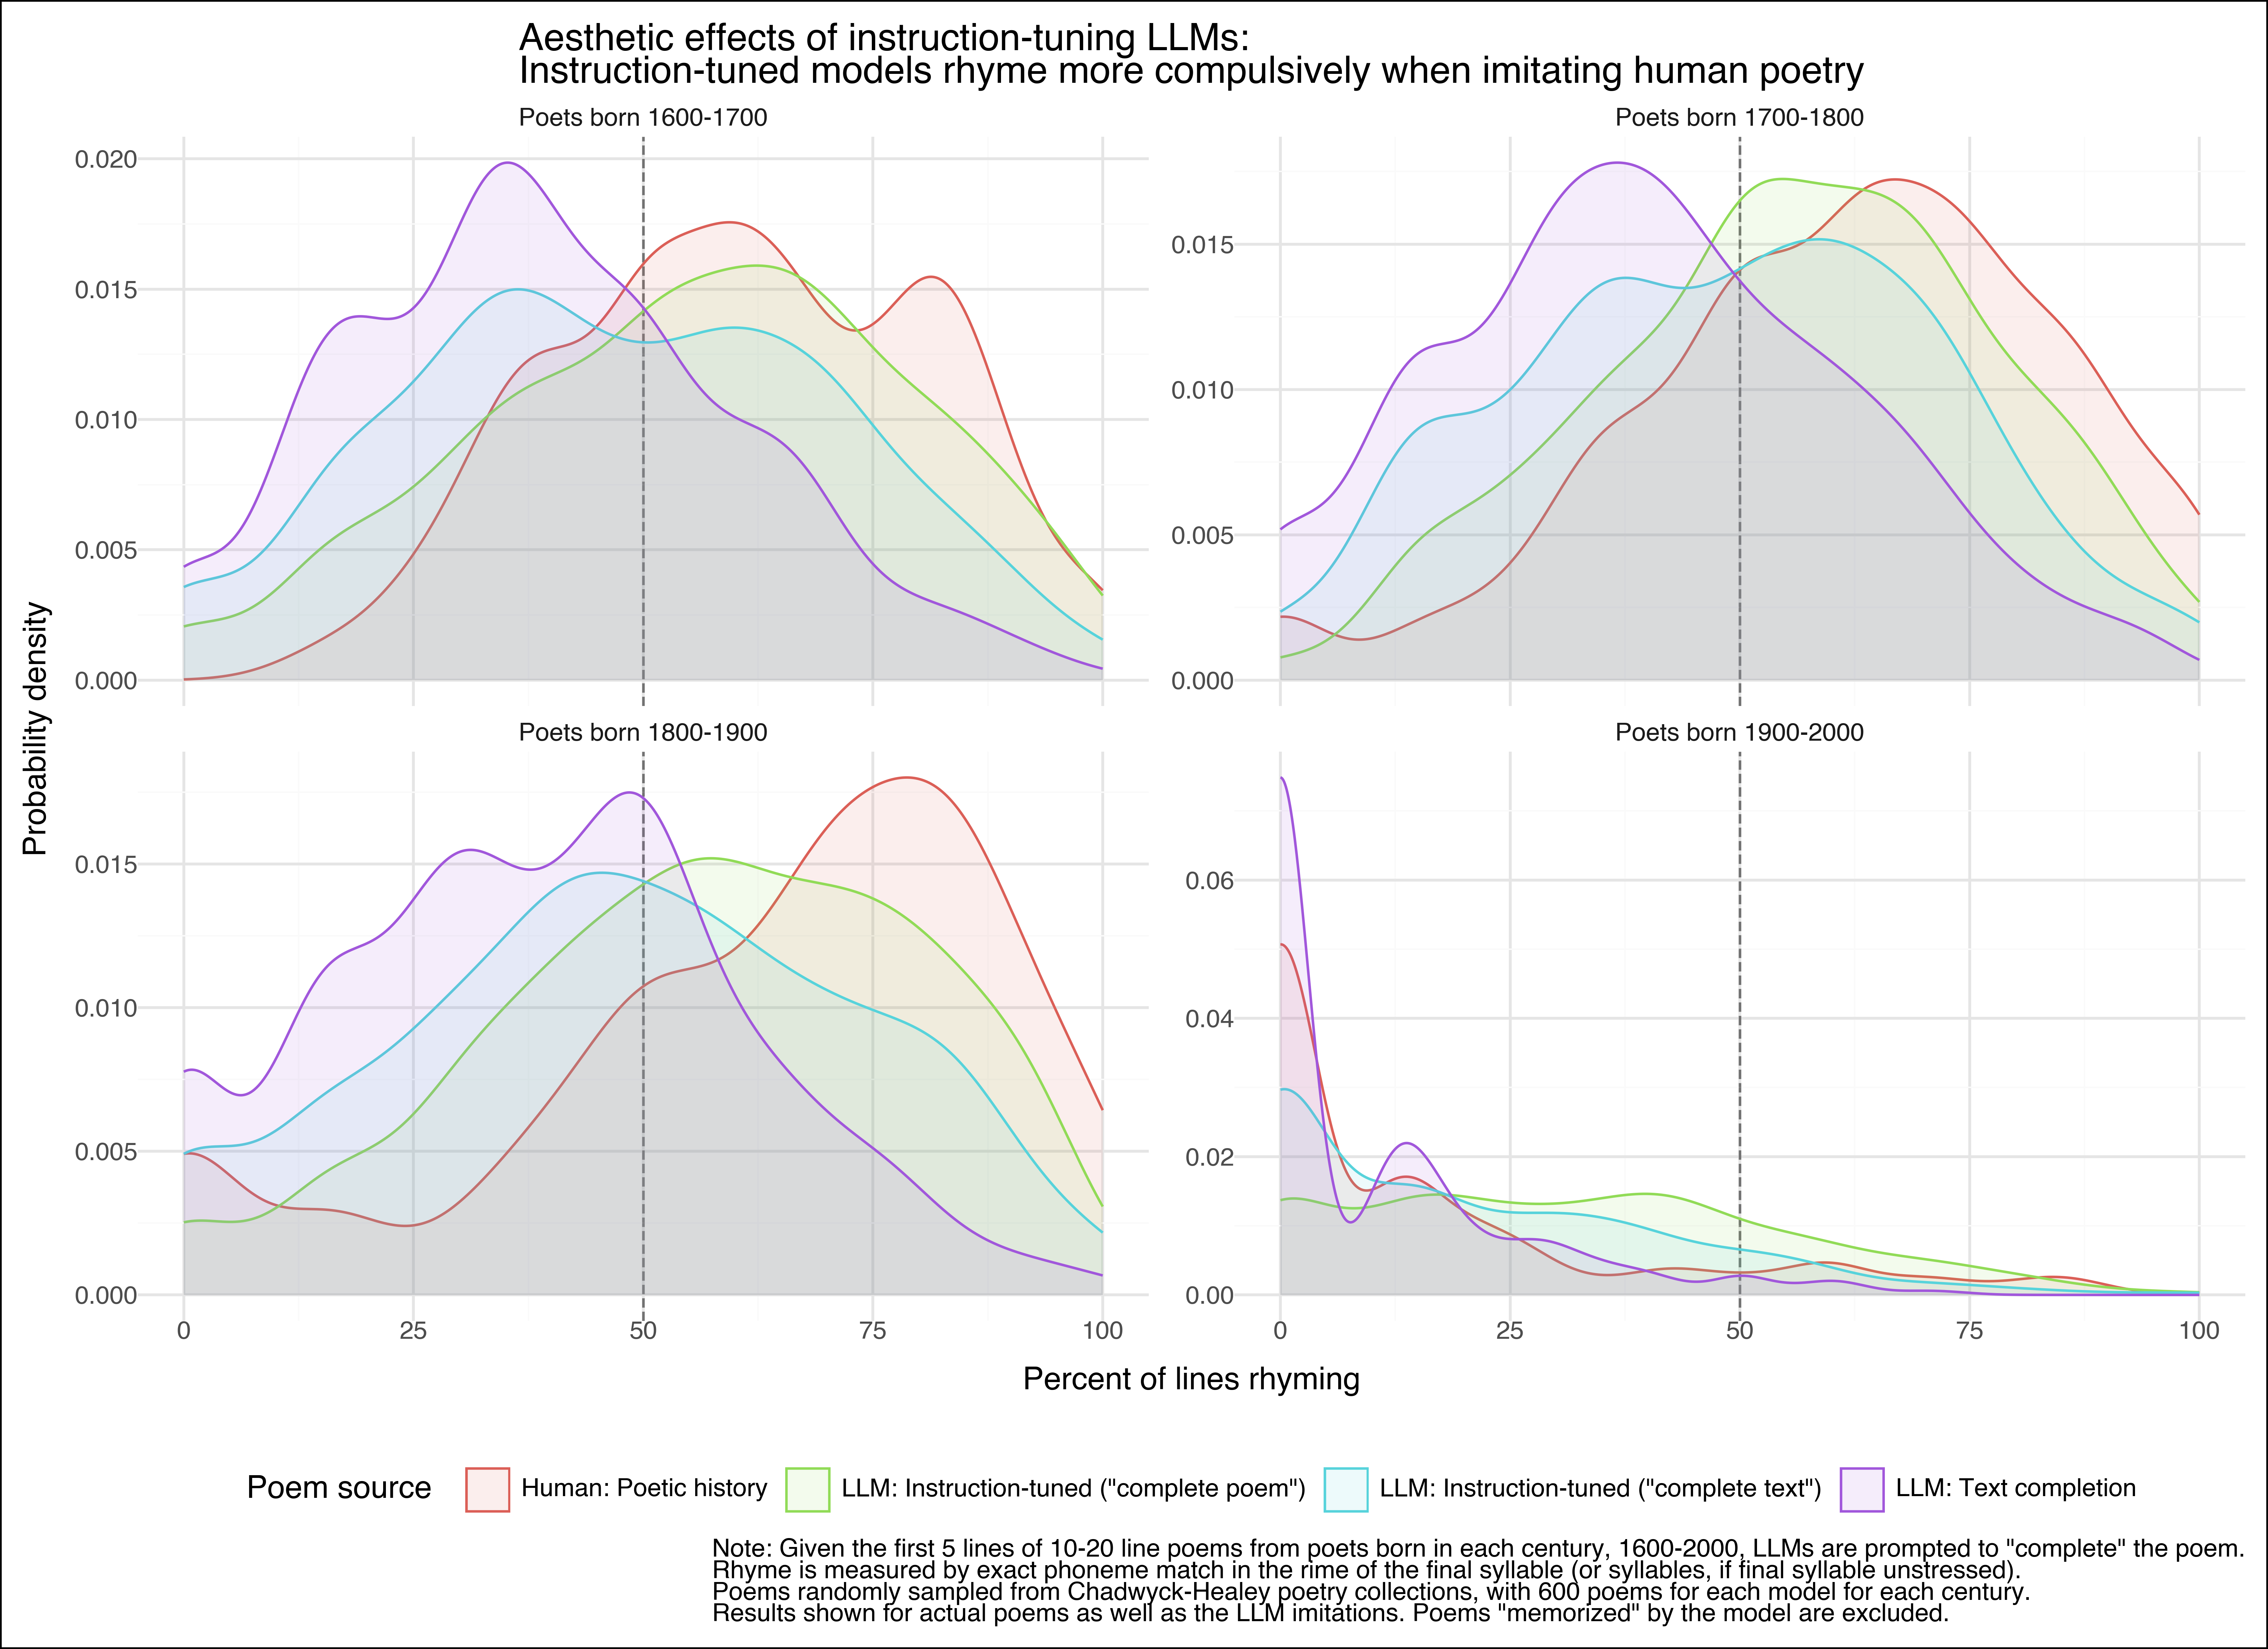

In [300]:
p9.options.figure_size=11,8
p9.options.dpi=300
fig = p9.ggplot(figdf, p9.aes(x='value', color='variable', fill='variable'))
fig+= p9.geom_vline(xintercept=50, linetype='dashed', alpha=.5)
# fig+= p9.geom_density(alpha=.1)
fig+= p9.geom_density(p9.aes(y=p9.after_stat('density')), alpha=.1)
# fig+= p9.geom_histogram(alpha=.5, position='identity', bins=20)  # adjust bins as needed
# fig+= p9.geom_freqpoly(alpha=.8, bins=20)
# fig+= p9.facet_wrap('ybin', nrow=2)
fig+= p9.facet_wrap('ybin', nrow=2, scales='free_y')
# fig+= p9.facet_grid('model~ybin')
fig+= p9.theme_minimal()
fig+= p9.theme(
    legend_position='bottom',
    plot_background=p9.element_rect(fill='white', color=None),  # Add white background
    panel_background=p9.element_rect(fill='white', color=None)  # Add white background to panels
)
fig+= p9.labs(
    y='Probability density',
    x='Percent of lines rhyming',
    color='Poem source',
    fill='Poem source',
    title='Aesthetic effects of instruction-tuning LLMs:\nInstruction-tuned models rhyme more compulsively when imitating human poetry',
    caption='Note: Given the first 5 lines of 10-20 line poems from poets born in each century, 1600-2000, LLMs are prompted to "complete" the poem.\nRhyme is measured by exact phoneme match in the rime of the final syllable (or syllables, if final syllable unstressed).\nPoems randomly sampled from Chadwyck-Healey poetry collections, with 600 poems for each model for each century.\nResults shown for actual poems as well as the LLM imitations. Poems "memorized" by the model are excluded.'
)
# fig+= p9.scale_y_continuous(limits=[0.0, 0.05])
fig.save(os.path.expanduser('~/Dropbox/Prof/Data/fig.rhyme_distros_by_century.v4.png'))
fig

In [61]:
# fig = p9.ggplot(figdf, p9.aes(x='value', color='ybin', fill='ybin'))
# fig+= p9.geom_vline(xintercept=50, linetype='dashed', alpha=.5)
# # fig+= p9.geom_density(alpha=.1)
# fig+= p9.geom_density(p9.aes(y=p9.after_stat('density')), alpha=.1)
# # fig+= p9.geom_histogram(alpha=.5, position='identity', bins=20)  # adjust bins as needed
# # fig+= p9.geom_freqpoly(alpha=.8, bins=20)
# fig+= p9.facet_wrap('variable', nrow=1)
# # fig+= p9.facet_grid('model~ybin')
# fig+= p9.theme_minimal()
# fig+= p9.theme(legend_position='bottom')
# fig+= p9.labs(
#     y='Probability',
#     x='Percent of lines rhyming',
#     color='Poem source',
#     fill='Poem source'
# )
# # fig+= p9.scale_y_continuous(limits=[0.0, 0.05])
# fig.save(os.path.expanduser('~/Dropbox/Prof/Data/fig.rhyme_distros_by_model2.png'))
# fig

In [62]:
# odf.groupby(['ybin','model']).size().sort_values()

In [63]:
# p9.options.figure_size=(12,7)
# # figdf = odf[odf.model=='ollama/llama3.1:8b'].groupby('ybin').sample(200).melt(id_vars=['model', 'id','ybin'], value_vars=['perc_rhyming_lines_real', 'perc_rhyming_lines_gen'])
# figdf = odf.melt(id_vars=['model', 'id','ybin'], value_vars=['perc_rhyming_lines_real', 'perc_rhyming_lines_gen'])
# figdf['variable'] = [mdl  if v.endswith('_gen') else 'real' for v,mdl in zip(figdf.variable, figdf.model)]
# figdf = figdf.groupby(['variable','ybin']).sample(250, replace=True)#.drop_duplicates('id')
# # # figdf = figdf[figdf.ybin!="b. 1950-2000"]
# fig = p9.ggplot(figdf, p9.aes(x='value', color='ybin', fill='ybin'))
# fig+= p9.geom_vline(xintercept=50, linetype='dashed', alpha=.5)
# # fig+= p9.geom_density(p9.aes(y=p9.after_stat('density')), alpha=.1)
# fig+= p9.geom_density(p9.aes(y=p9.after_stat('density')), alpha=.1)
# fig+= p9.facet_wrap('variable', nrow=2)
# # fig+= p9.facet_grid('model~ybin')
# fig+= p9.theme_minimal()
# # fig+= p9.scale_y_continuous(limits=[0.0, 0.05])
# fig.save(os.path.expanduser('~/Dropbox/Prof/Data/fig.rhyme_distros_by_model.png'))
# fig

In [ ]:
def get_eg_poems(df, max_diff=True, n=1):
    if max_diff is not None:
        df = df.sort_values('perc_rhyming_lines_diff', ascending=not max_diff)
    else:
        df['perc_rhyming_lines_diff_abs'] = df['perc_rhyming_lines_diff'].abs()
        df = df.sort_values('perc_rhyming_lines_diff_abs')
    
    row = df.head(200).sample(1).iloc[0]

    poem_real = [ln.strip()[0].upper() + ln.strip()[1:] if ln.strip() else ln for ln in row.poem_real.split('\n')]
    poem_gen = [ln.strip()[0].upper() + ln.strip()[1:] if ln.strip() else ln for ln in row.poem_gen.split('\n')]

    key_real,key_gen = 'A','B'
    if random.random()>.5:
        poem_real,poem_gen = poem_gen,poem_real
        key_real,key_gen = key_gen,key_real

    # Find the maximum width needed for the real poem
    max_width = max(len(line) for line in poem_real)
    
    print(f"Poem {n}A".ljust(max_width + 4) + f"Poem {n}B")
    # print("-" * (max_width + 4) + "-" * 40)  # Separator line
    
    # Zip the poems together, with empty strings if one is shorter
    for real_line, gen_line in itertools.zip_longest(poem_real, poem_gen, fillvalue=""):
        print(f"{real_line:<{max_width + 4}}{gen_line}")

    
    row_meta = df_meta.loc[row.id]
    key_real_str = f'\t{n}{key_real}: "{row_meta.title.replace('&hyphen;','-')}" by {row_meta.author}'
    key_gen_str = f'\t{n}{key_gen}: AI imitation by {row.model.split('/')[-1]}'

    print()
    if key_real=='A':
        print(key_real_str)
        print(key_gen_str)
    else:
        print(key_gen_str)
        print(key_real_str)
    # return row

get_eg_poems(odf2, max_diff=None)

In [ ]:
for n in range(5):
    get_eg_poems(odf2[~odf2.model.str.contains('olmo')].query('ybin=="b. 1900-2000"'), max_diff=None, n=n+1)
    print('\n\n')

In [89]:
row=df_meta.loc['english/wyvillsi/Z200544979']

In [ ]:
row.dropna()